In [1]:
import os

IMG_PATH = "_img"
CACHE_PATH = "../fitting/_cache"
if not os.path.isdir(IMG_PATH): os.mkdir(IMG_PATH)
if not os.path.isdir(CACHE_PATH): os.mkdir(CACHE_PATH)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(context="talk", style="ticks", palette="colorblind", color_codes=True)

from astropy.io import fits
from astropy.table import Table

from MaStarChecks.constants import R_V
from MaStarChecks.plotting.styles import GSL_COLOR, Y19_COLOR, MASTAR_CMAP, MASTAR_COLOR, LIGHT_COLOR, MED_COLOR
from MaStarChecks.plotting.analysis import build_comparison_table, delta_inset_plot


Y_COLUMNS = ["TEFF", "LOGG", "FEH", "AVDUST"]

units = dict(zip(Y_COLUMNS, [r"K", r"", r"", r"mag"]))
cols = {label:f"{column}~({unit})" if unit else column for label, column, unit in zip(Y_COLUMNS, [r"$T_\mathrm{eff}$", r"$\log{g}$", r"$[\mathrm{Fe}/\mathrm{H}]$", r"$A_V$"], units.values())}

In [16]:
# load CoSHA catalogue
cosha_mwm_path = "_data/get_MWM_CoSha.csv"
with open(cosha_mwm_path, "r") as cosha_file:
    line = cosha_file.readline()[:-1]
    header = []
    while line.startswith("#"):
        header.append(line.split()[-1].strip())
        line = cosha_file.readline()[:-1]
cosha_mwm = pd.read_csv(cosha_mwm_path, comment="#", names=header)
cosha_mwm = cosha_mwm.filter(items=("NAME", "TEFF", "LOGG", "FEH", "EBV"))
cosha_mwm = cosha_mwm.set_index("NAME")
cosha_mwm["AVDUST"] = R_V * cosha_mwm["EBV"]

# load DAP catalogue
dap_mwm_path = "_data/get_MWM_DAP.csv"
with open(dap_mwm_path, "r") as dap_file:
    line = dap_file.readline()[:-1]
    header = []
    while line.startswith("#"):
        header.append(line.split()[-1].strip())
        line = dap_file.readline()[:-1]
dap_mwm = pd.read_csv(dap_mwm_path, comment="#", names=header)
dap_mwm = dap_mwm.filter(items=("NAME", "TEFF", "LOGG", "FEH", "AVDUST"))
dap_mwm = dap_mwm.set_index("NAME")

# load MWM catalogue
# mwm_catalogue_path = "/disk-a/mejia/mastar-checks-data/stellar-libraries/MWM/v6_0_4/spAll-v6_0_4.fits"
mwm_catalogue_path = "../../../MWM/WD4/SDSS-V/v6_0_4/spAll-v6_0_4.fits"
mwm_fits = fits.open(mwm_catalogue_path)
names = ["FILENAME", "PLUG_RA", "PLUG_DEC", "CLASS", "XCSAO_TEFF", "XCSAO_LOGG", "XCSAO_FEH", "SFD_EBV"]
xcsao_table = Table(mwm_fits[1].data)
if "FILENAME" not in xcsao_table.columns:
    spec_names = [f"spec-{plate:05d}-{mjd}-{catid:011d}" for catid, mjd, plate in xcsao_table.iterrows("CATALOGID", "MJD", "PLATE")]
    xcsao_table.add_column(spec_names, name="FILENAME")
xcsao_mwm = xcsao_table[names].to_pandas()
xcsao_mwm = xcsao_mwm.loc[xcsao_mwm.CLASS.str.strip() == "STAR"]
xcsao_mwm = xcsao_mwm.rename(columns={"FILENAME":"NAME"}).rename(columns=lambda name: name.replace("XCSAO_", ""))
xcsao_mwm = xcsao_mwm.set_index("NAME")
xcsao_mwm["AVDUST"] = R_V * xcsao_mwm["SFD_EBV"]

In [44]:
mwm_fits[1].columns

ColDefs(
    name = 'PROGRAMNAME'; format = '12A'
    name = 'CHUNK'; format = '17A'
    name = 'SURVEY'; format = '7A'
    name = 'PLATEQUALITY'; format = '4A'
    name = 'PLATESN2'; format = 'E'
    name = 'DEREDSN2'; format = 'E'
    name = 'PRIMTARGET'; format = 'J'
    name = 'SECTARGET'; format = 'J'
    name = 'LAMBDA_EFF'; format = 'E'
    name = 'BLUEFIBER'; format = 'J'
    name = 'ZOFFSET'; format = 'E'
    name = 'XFOCAL'; format = 'E'
    name = 'YFOCAL'; format = 'E'
    name = 'SPECPRIMARY'; format = 'B'
    name = 'SPECBOSS'; format = 'B'
    name = 'BOSS_SPECOBJ_ID'; format = 'J'
    name = 'NSPECOBS'; format = 'I'
    name = 'CALIBFLUX'; format = '5E'
    name = 'CALIBFLUX_IVAR'; format = '5E'
    name = 'GAIA_BP'; format = 'E'
    name = 'GAIA_RP'; format = 'E'
    name = 'GAIA_G'; format = 'E'
    name = 'FIRSTCARTON'; format = '48A'
    name = 'MAG'; format = '5E'
    name = 'PLATE'; format = 'I'
    name = 'DESIGNID'; format = 'I'
    name = 'NEXP'; format = 'I'
 

In [25]:
from astropy.coordinates import SkyCoord
from astropy import units as u


mwm_coords = SkyCoord(ra=xcsao_mwm.PLUG_RA.values*u.deg, dec=xcsao_mwm.PLUG_DEC.values*u.deg)
mwm_coords

xcsao_mwm["gal_b"] = mwm_coords.galactic.b.to(u.deg).value

In [3]:
cosha_mwm.head()

TEFF      LOGG       FEH       EBV  \
NAME                                                                      
spec-15000-59146-04375786564  4995.412235  3.357795 -2.452246  0.009511   
spec-15000-59146-04375786575  5785.956533  3.491458 -1.693828  0.047578   
spec-15000-59146-04375787016  4915.282284  2.653119 -1.765261  0.025636   
spec-15000-59146-04375787024  5531.499650  4.332331 -2.351814  0.027398   
spec-15000-59146-04375787075  7380.010979  2.137235 -3.674904  0.005972   

                                AVDUST  
NAME                                    
spec-15000-59146-04375786564  0.029484  
spec-15000-59146-04375786575  0.147491  
spec-15000-59146-04375787016  0.079472  
spec-15000-59146-04375787024  0.084933  
spec-15000-59146-04375787075  0.018513

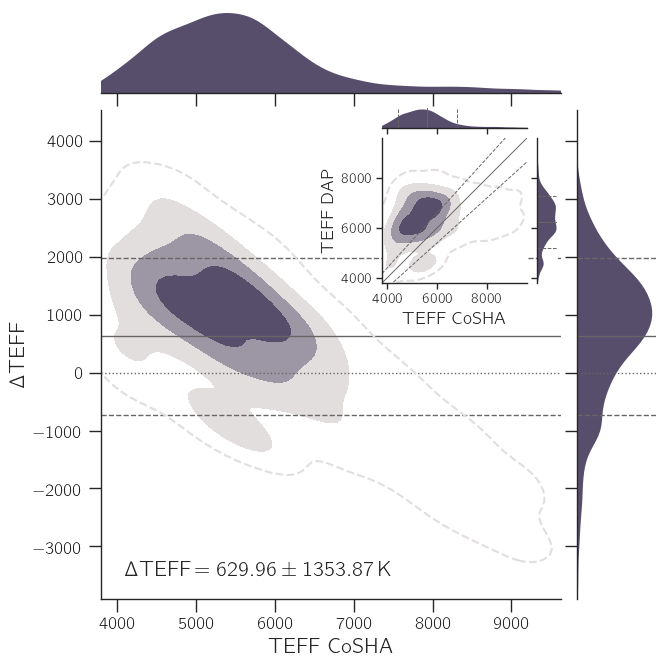

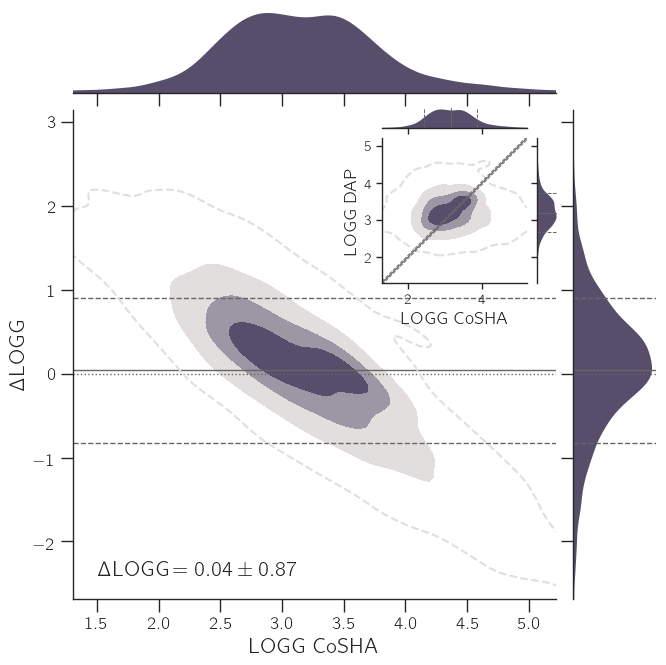

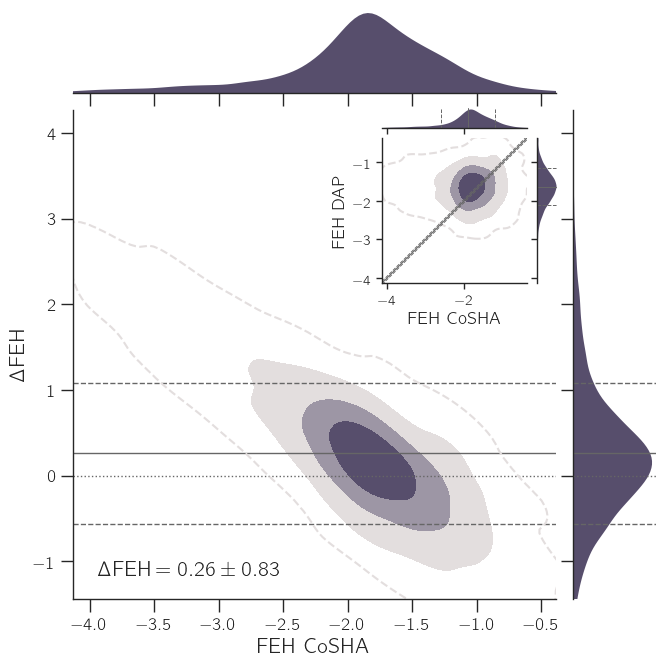

In [50]:
dap_mwm.TEFF = dap_mwm.TEFF/1.25*(1.25*2.5)
comp_table = build_comparison_table(dap_mwm, cosha_mwm, "DAP", "CoSHA", columns=["TEFF", "LOGG", "FEH", "AVDUST"])

for label, column in cols.items():
    d = delta_inset_plot(
        comparison_table=comp_table,
        column=label, unit=units.get(label,""), is_logscale=label!="TEFF",
        labelx="CoSHA", labely="DAP", delta_prefix=r"$\Delta$", guide_color="0.4"
    )

# 

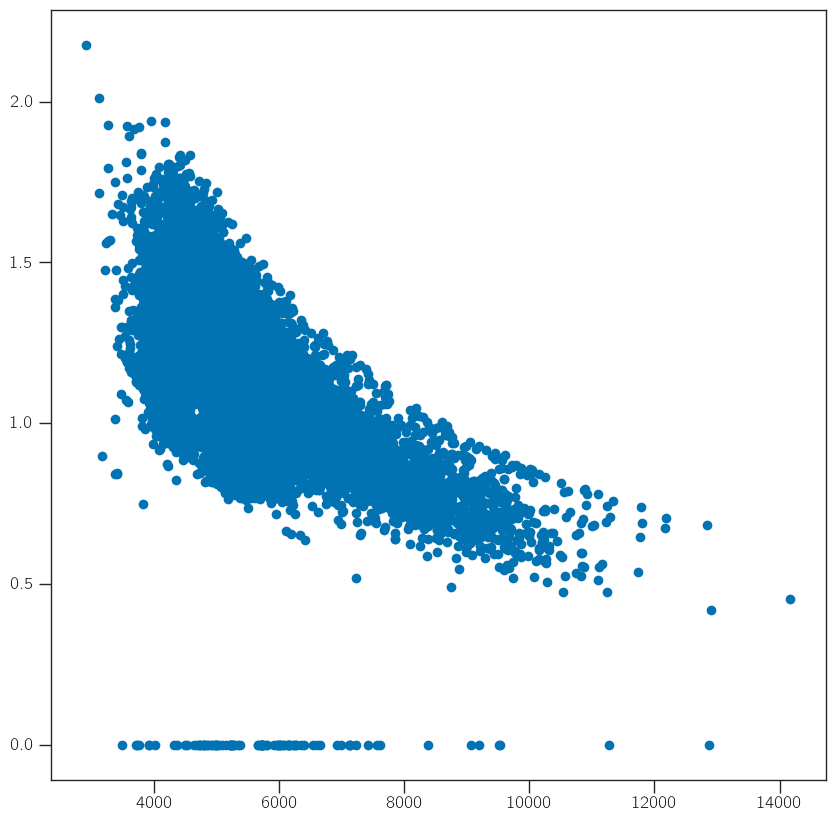

In [52]:
plt.scatter(comp_table["TEFF CoSHA"], comp_table["TEFF DAP"] / comp_table["TEFF CoSHA"])

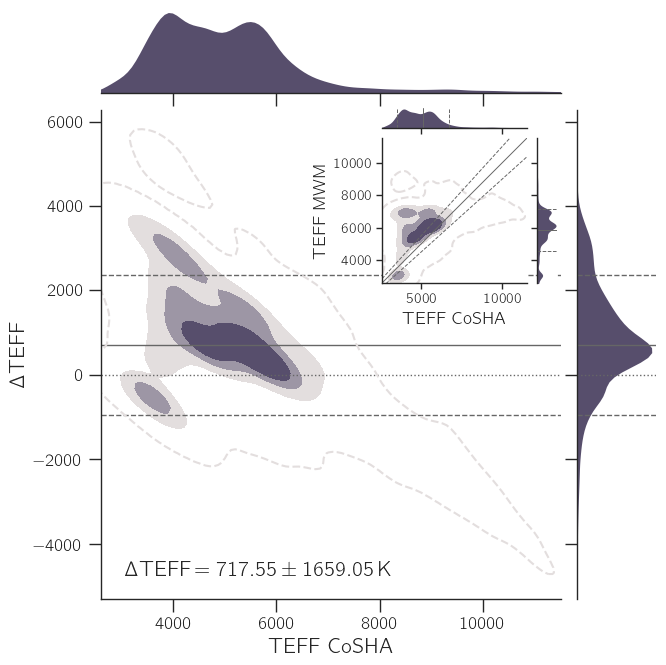

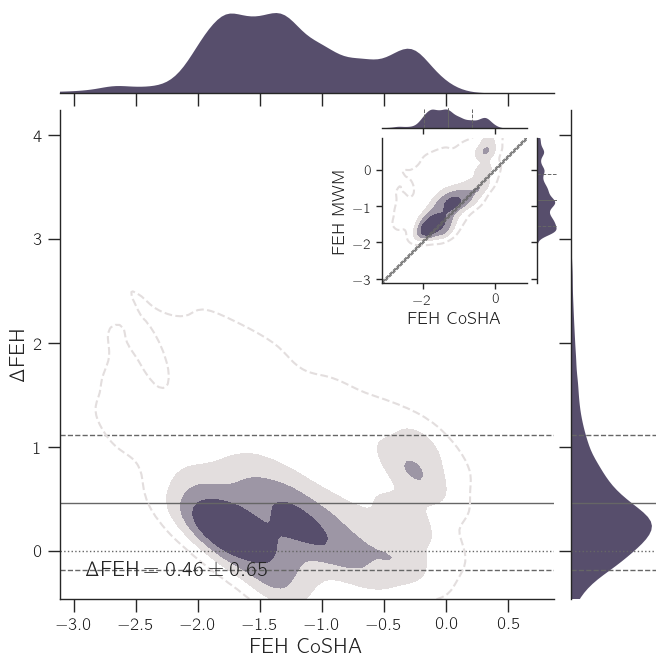

In [5]:
comp_table = build_comparison_table(xcsao_mwm, cosha_mwm, "MWM", "CoSHA", columns=["TEFF", "LOGG", "FEH", "AVDUST"])

for label, column in cols.items():
    d = delta_inset_plot(
        comparison_table=comp_table,
        column=label, unit=units.get(label,""), is_logscale=label!="TEFF",
        labelx="CoSHA", labely="MWM", delta_prefix=r"$\Delta$", guide_color="0.4"
    )

In [47]:
r_v = (dap_mwm.AVDUST/xcsao_mwm.AVDUST/3.1).dropna()
x = (xcsao_mwm.AVDUST/3.1).loc[r_v.index]
gal_b = xcsao_mwm.gal_b.loc[r_v.index]
plt.scatter(x, r_v, c=gal_b, lw=0, s=10)
# plt.scatter(gal_b, (dap_mwm.AVDUST-xcsao_mwm.AVDUST).dropna(), c=xcsao_mwm.AVDUST.loc[gal_b.index])
plt.colorbar()

# take care of low galactic latitude stars


Text(0.5, 0, 'Av(DAP - MWM)')

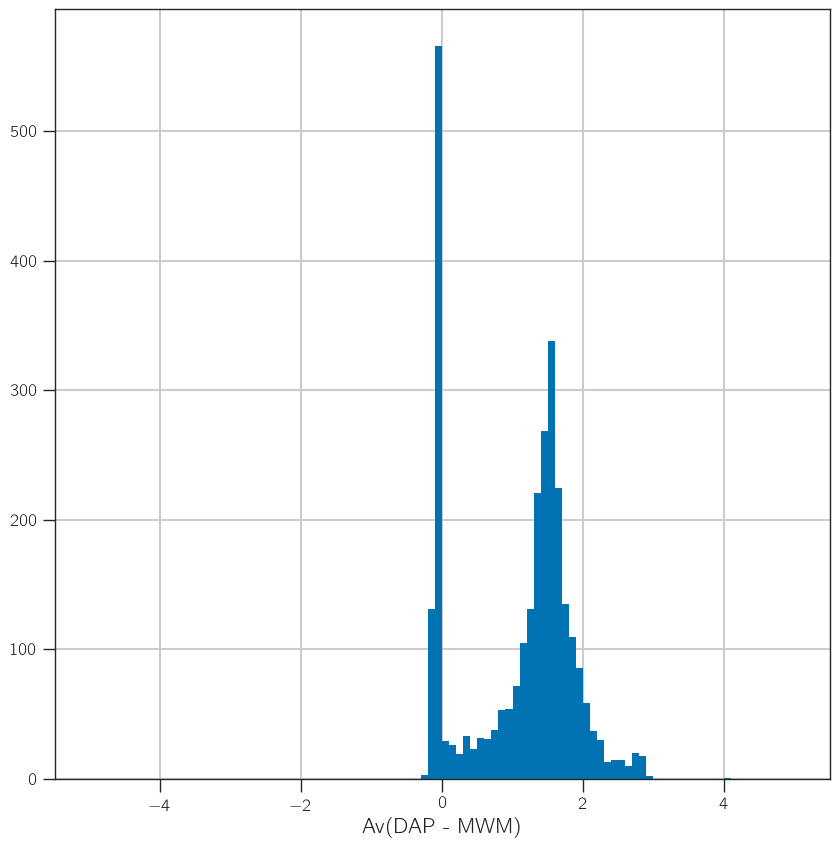

In [37]:
(dap_mwm.AVDUST-xcsao_mwm.AVDUST).dropna().hist(range=(-5,5), bins=100)
plt.xlabel(r"Av(DAP - MWM)")

Text(0.5, 0, 'Av(CoSHA - MWM)')

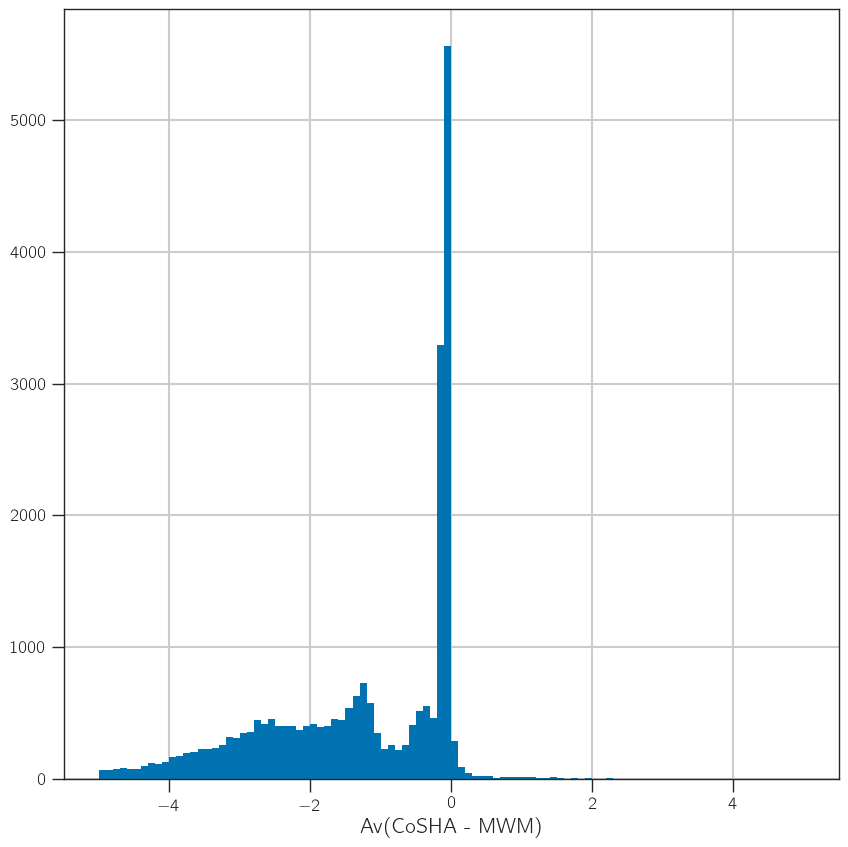

In [13]:
(cosha_mwm.AVDUST-xcsao_mwm.AVDUST).dropna().hist(range=(-5,5), bins=100)
plt.xlabel(r"Av(CoSHA - MWM)")

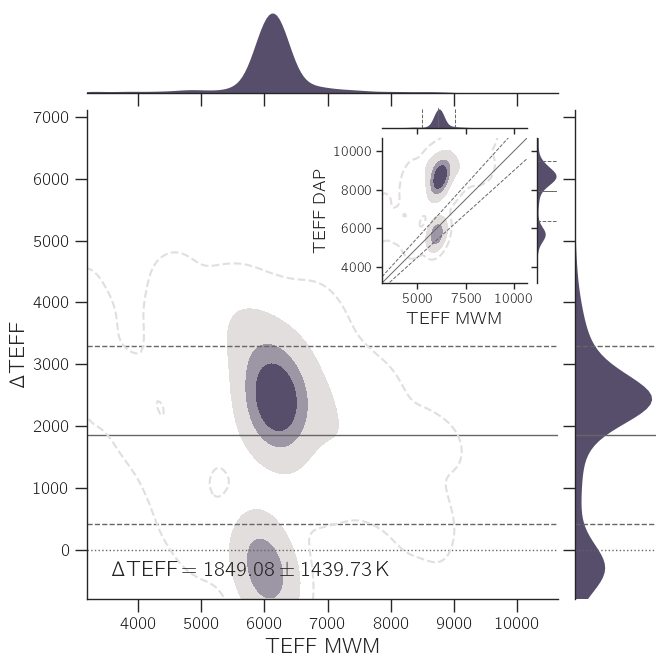

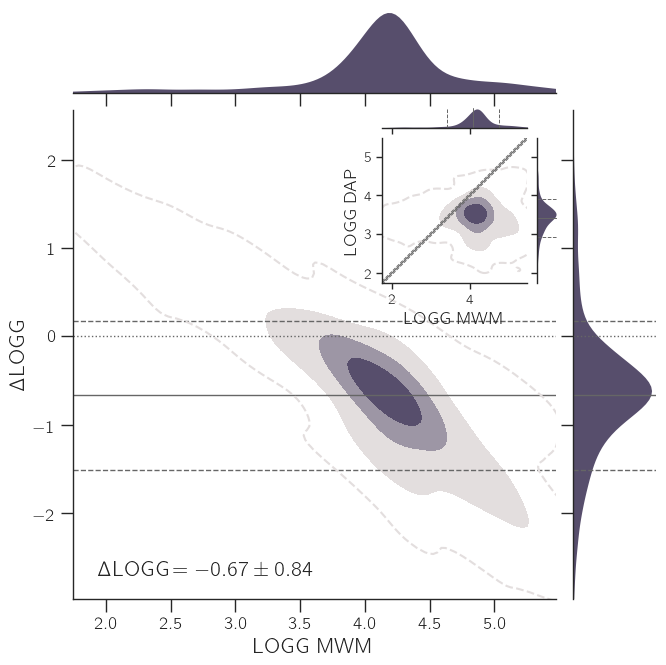

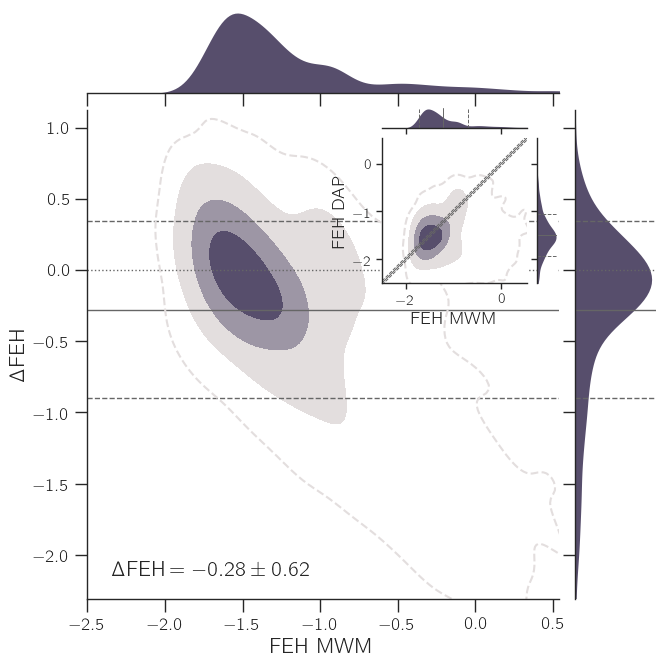

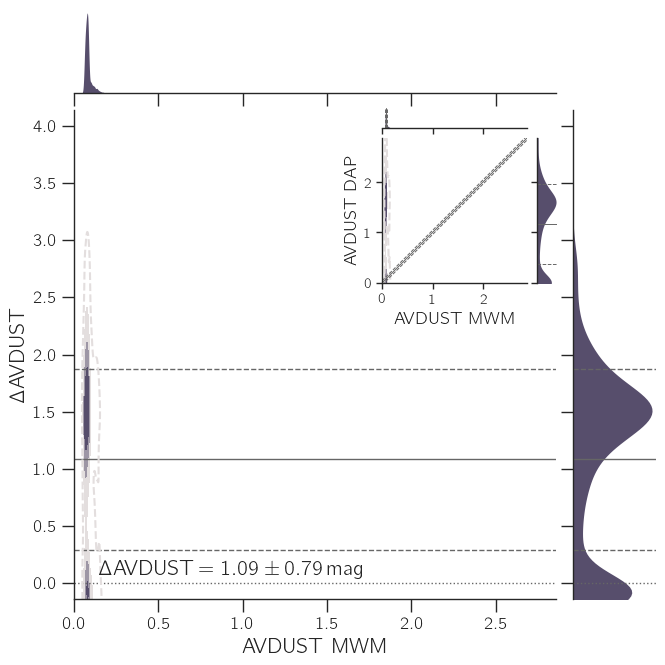

In [8]:
comp_table = build_comparison_table(dap_mwm, xcsao_mwm, "DAP", "MWM", columns=["TEFF", "LOGG", "FEH", "AVDUST"])

for label, column in cols.items():
    d = delta_inset_plot(
        comparison_table=comp_table,
        column=label, unit=units.get(label,""), is_logscale=label!="TEFF",
        labelx="MWM", labely="DAP", delta_prefix=r"$\Delta$", guide_color="0.4"
    )